In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed


  Signal_Date Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  Shares_After  \
0  2022-11-21    BUY 2022-11-22      146.069937      146.142972     34.213072   
1  2022-11-29   SELL 2022-11-30      139.433528      139.363811      0.000000   
2  2022-12-01    BUY 2022-12-02      143.930147      144.002112     33.909447   
3  2022-12-19   SELL 2022-12-20      129.562765      129.497984      0.000000   
4  2023-02-03    BUY 2023-02-06      150.448218      150.523442     21.050802   

    Cash_After  commission  shares_delta  
0  4999.000000         1.0     34.213072  
1  9766.064086         1.0    -34.213072  
2  4882.032043         1.0     33.909447  
3  9272.237122         1.0    -33.909447  
4  6102.598003         1.0     21.050802  
                 Close       MA_20       MA_50  Signal     Portfolio
Date                                                                
2025-08-14  232.779999  215.608177  208.795386       0  10353.840077
2025-08-15  231.589996  216.640647  209.375384  

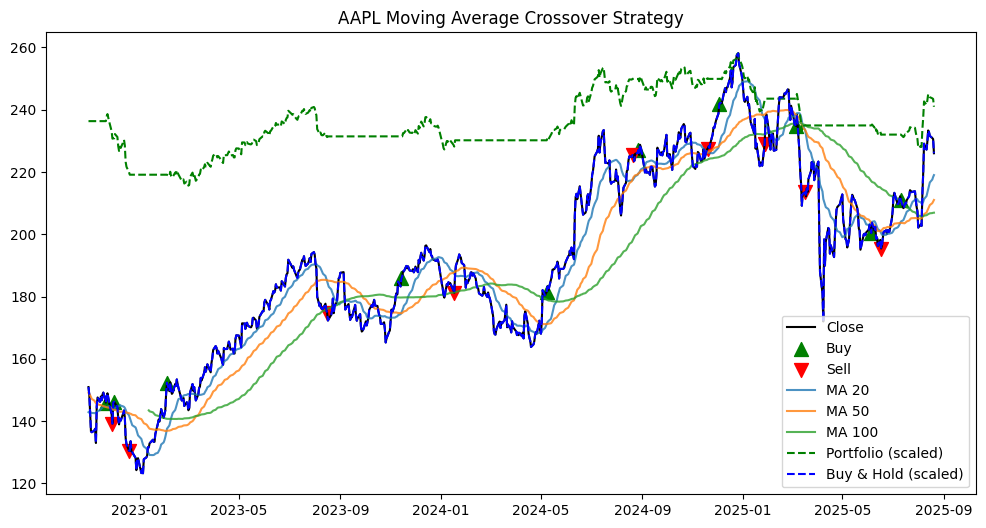

In [30]:
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.10
vol_lookback = 30
eps = 1e-12

def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        return ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        return ValueError("unknown commison model")


df = yf.download("AAPL", period="3y", auto_adjust=True)

df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["MA_100"] = df["Close"].rolling(window=100).mean()

df["Signal"] = 0
df.loc[(df["MA_20"] > df["MA_50"]) & (df["MA_20"].shift(1) <= df["MA_50"].shift(1)), "Signal"] = 1  # Buy
df.loc[(df["MA_50"] > df["MA_20"]) & (df["MA_50"].shift(1) <= df["MA_20"].shift(1)), "Signal"] = -1 # Sell


df = df.dropna(subset=["MA_20", "MA_50"])

df["ExecPrice"] = df["Open"].shift(-1)
df = df.dropna(subset=["ExecPrice"])

starting_cash = 10000
cash = starting_cash
shares_held = 0
portfolio = []
trades = []
total_commission_paid = 0.0
total_slippage_cost = 0.0

daily_ret = df["Close"].pct_change()
#print(daily_ret)
df["anl_vol"] = daily_ret.rolling(vol_lookback).std() * np.sqrt(252)
exp_flag = []

for i in range(len(df)):
    current_price = df["Close"].iloc[i]
    signal = df["Signal"].iloc[i]
    exec_price = df["ExecPrice"].iloc[i]

    equity = cash + (shares_held * current_price)
    portfolio.append(equity)

    if shares_held > 0:
        exp_flag.append(1)
    else:
        exp_flag.append(0)

    # Buy signal
    if signal == 1:
        fixed_frac = aloc_frac

        vol_today = df["anl_vol"].iloc[i]
        if pd.notna(vol_today) and vol_today > 0:
            vol_frac = vol_target / max(vol_today, eps)
        else :
            vol_frac = fixed_frac
        
        target_frac = min(fixed_frac, vol_frac, max_capital_frac)
        target_value = target_frac * equity
        px_eff = effective_price("BUY", exec_price, slippage_bps)
        target_shares = target_value / px_eff
        shares_delta = max(target_shares - shares_held, 0.0)
        comm = commission_value(commission_model, shares_delta ,px_eff)

        if shares_delta * px_eff + comm > cash:
            shares_delta = max((cash-comm)/px_eff, 0.0)
        if shares_delta == 0.0:
            comm = 0.0
        
        cash -= shares_delta * px_eff + comm
        shares_held += shares_delta
        total_commission_paid += comm
        total_slippage_cost += (px_eff - exec_price) * shares_delta

        trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
    
    # Sell signal
    elif signal == -1 and shares_held > 0:
        px_eff = effective_price("SELL", exec_price, slippage_bps)
        shares_to_sell = shares_held
        proceeds = shares_to_sell * px_eff
        comm = commission_value(commission_model, shares_to_sell, px_eff)
        
        cash += proceeds - comm
        shares_held = 0
        total_commission_paid += comm
        total_slippage_cost += (exec_price - px_eff) * shares_to_sell
        shares_delta = -shares_to_sell
        trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))

df["Portfolio"] = portfolio
trades_df = pd.DataFrame(trades, columns=[
    "Signal_Date", "Action", "Exec_Date", "Exec_Price_Raw", "Exec_Price_eff", "Shares_After", "Cash_After", "commission", "shares_delta"
])
print(trades_df.head(5))

print(df[["Close", "MA_20", "MA_50", "Signal", "Portfolio"]].tail())
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]

shares_bh = starting_cash / df["Close"].iloc[0]
df["BuyHold"] = shares_bh * df["Close"]

# === Performance Metrics Function ===
def performance_metrics(portfolio_values, daily_returns):
    total_return = (portfolio_values[-1] - starting_cash) / starting_cash
    avg_daily = daily_returns.mean()
    std_daily = daily_returns.std()
    annual_return = (1 + avg_daily)**252 - 1
    sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily > 0 else np.nan
    cummax = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cummax) / cummax
    max_dd = drawdowns.min()
    return total_return, annual_return, sharpe, max_dd

# === Calculate Metrics ===
strategy_metrics = performance_metrics(df["Portfolio"].values, df["Portfolio"].pct_change().dropna())
bh_metrics = performance_metrics(df["BuyHold"].values, df["BuyHold"].pct_change().dropna())
exposure_pct = np.mean(exp_flag)
traded_notional = (trades_df["shares_delta"].abs() * trades_df["Exec_Price_eff"]).sum()
avg_equity = float(df["Portfolio"].mean())
turnover = traded_notional / max(avg_equity, eps)

# === Create Comparison Report ===
report = pd.DataFrame({
    "Strategy": strategy_metrics,
    "Buy & Hold": bh_metrics
}, index=["Total Return", "Annualized Return", "Sharpe Ratio", "Max Drawdown"])

print("\n=== Performance Comparison ===")
print(report)
print(f"\nTotal trades: {len(trades_df)} | Total commissions: ${total_commission_paid:.2f} | "
      f"Total slippage cost: ${total_slippage_cost:.2f}")
print(f"Turnover: {turnover:.2f}x over the period")
print(f"Exposure: {exposure_pct:.2%}")




# === Plot ===
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close", color="black")
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell", s=100)
plt.plot(df.index, df["MA_20"], label="MA 20", alpha=0.8)
plt.plot(df.index, df["MA_50"], label="MA 50", alpha=0.8)
plt.plot(df.index, df["MA_100"], label="MA 100", alpha=0.8)
plt.plot(df.index, df["Portfolio"]/max(df["Portfolio"])*max(df["Close"]), 
         label="Portfolio (scaled)", linestyle="--", color="green")  # scaled for visibility
plt.plot(df.index, df["BuyHold"]/df["BuyHold"].iloc[0]*df["Close"].iloc[0],
         label="Buy & Hold (scaled)", linestyle="--", color="blue")
plt.legend()
plt.title("AAPL Moving Average Crossover Strategy")
plt.show()


